# Functions

## Rotor system

In [45]:
import numpy as np
from scipy.linalg import eig

class RotorSystem:
    def __init__(self, beam, discs, bearings, Omega=0):
        self.L = beam['length']
        self.Douter = beam['D_outer']
        self.Dinner = beam.get('D_inner', 0)
        self.rho = beam['density']
        self.E = beam['E']
        self.n_elem = beam['n_elem']
        self.Omega = Omega

        self.discs = discs
        self.bearings = bearings

        self.I = (np.pi / 64) * (self.Douter**4 - self.Dinner**4)
        self.A = (np.pi / 4) * (self.Douter**2 - self.Dinner**2)
        self.n_nodes = self.n_elem + 1
        self.dof_per_node = 4
        self.total_dof = self.n_nodes * self.dof_per_node
        self.dx = self.L / self.n_elem

        self.M_global = np.zeros((self.total_dof, self.total_dof))
        self.K_global = np.zeros((self.total_dof, self.total_dof))
        self.G_global = np.zeros((self.total_dof, self.total_dof))

    def beam_element_matrices_3D(self):
        l = self.dx
        E, I = self.E, self.I
        rho, A = self.rho, self.A
        Douter, Dinner = self.Douter, self.Dinner

        Theta_p = 0.5 * rho * A * ((Douter / 2)**2 - (Dinner / 2)**2)
        Theta_d = 0.25 * rho * A * ((Douter / 2)**2 - (Dinner / 2)**2)

        t2 = l**2
        t3 = l**3
        t4 = A * l * rho * (13.0 / 35.0)
        t5 = A * l * rho * (9.0 / 70.0)
        t6 = (A * rho * t3) / 105.0
        t7 = (A * rho * t3) / 140.0
        t8 = -t7
        t9 = A * rho * t2 * (11.0 / 210.0)
        t10 = A * rho * t2 * (13.0 / 420.0)
        t11 = -t9
        t12 = -t10

        Mt = np.array([
            [t4,t11,0,0,t5,t10,0,0],
            [t11,t6,0,0,t12,t8,0,0],
            [0,0,t4,t11,0,0,t5,t10],
            [0,0,t11,t6,0,0,t12,t8],
            [t5,t12,0,0,t4,t9,0,0],
            [t10,t8,0,0,t9,t6,0,0],
            [0,0,t5,t12,0,0,t4,t9],
            [0,0,t10,t8,0,0,t9,t6]
        ])

        t2 = 1.0 / l
        t3 = Theta_p / 10.0
        t4 = Theta_p * l * (2.0 / 15.0)
        t5 = (Theta_p * l) / 30.0
        t6 = -t3
        t7 = -t5
        t8 = Theta_p * t2 * (6.0 / 5.0)
        t9 = -t8

        Mr = np.array([
            [t8,t6,0,0,t9,t6,0,0],
            [t6,t4,0,0,t3,t7,0,0],
            [0,0,t8,t6,0,0,t9,t6],
            [0,0,t6,t4,0,0,t3,t7],
            [t9,t3,0,0,t8,t3,0,0],
            [t6,t7,0,0,t3,t4,0,0],
            [0,0,t9,t3,0,0,t8,t3],
            [0,0,t6,t7,0,0,t3,t4]
        ])

        M = Mr + Mt

        t3 = Theta_d / 10.0
        t4 = -t3
        t5 = Theta_d * l * (2.0 / 15.0)
        t6 = (Theta_d * l) / 30.0
        t7 = -t5
        t8 = -t6
        t9 = Theta_d * t2 * (6.0 / 5.0)
        t10 = -t9

        G = np.array([
            [0,0,t9,t4,0,0,t10,t4],
            [0,0,t4,t5,0,0,t3,t8],
            [t10,t3,0,0,t9,t3,0,0],
            [t3,t7,0,0,t4,t6,0,0],
            [0,0,t10,t3,0,0,t9,t3],
            [0,0,t4,t8,0,0,t3,t5],
            [t9,t4,0,0,t10,t4,0,0],
            [t3,t6,0,0,t4,t7,0,0]
        ])

        t2 = 1.0 / l
        t3 = t2**2
        t4 = t2**3
        t5 = 2 * E * I * t2
        t6 = 4 * E * I * t2
        t7 = 6 * E * I * t3
        t8 = -t7
        t9 = 12 * E * I * t4
        t10 = -t9

        K = np.array([
            [t9,t8,0,0,t10,t8,0,0],
            [t8,t6,0,0,t7,t5,0,0],
            [0,0,t9,t8,0,0,t10,t8],
            [0,0,t8,t6,0,0,t7,t5],
            [t10,t7,0,0,t9,t7,0,0],
            [t8,t5,0,0,t7,t6,0,0],
            [0,0,t10,t7,0,0,t9,t7],
            [0,0,t8,t5,0,0,t7,t6]
        ])

        return K, M, G

    def assemble_global_matrices(self):
        for e in range(self.n_elem):
            K_e, M_e, G_e = self.beam_element_matrices_3D()
            dof_map = [4*e+i for i in range(8)]

            for i in range(8):
                for j in range(8):
                    self.K_global[dof_map[i], dof_map[j]] += K_e[i, j]
                    self.M_global[dof_map[i], dof_map[j]] += M_e[i, j]
                    self.G_global[dof_map[i], dof_map[j]] += G_e[i, j]

        self.add_discs()

    def add_discs(self):
        for disc in self.discs:
            r = disc['diameter'] / 2
            m = disc['density'] * np.pi * r**2 * disc['thickness']
            Theta_d = (1/4) * m * r**2
            Theta_p = 0.5 * m * r**2

            node = int(np.clip(disc['pos'], 0, self.n_nodes - 1))
            dofs = [4*node + i for i in range(4)]

            M_local = np.diag([m, Theta_p, m, Theta_p])

            G_local = np.zeros((4, 4))
            G_local[1, 3] = -Theta_d * self.Omega
            G_local[3, 1] = Theta_d * self.Omega

            for i in range(4):
                for j in range(4):
                    self.M_global[dofs[i], dofs[j]] += M_local[i, j]
                    self.G_global[dofs[i], dofs[j]] += G_local[i, j]

    def apply_boundary_conditions(self):
        self.constrained_dofs = []
        for bearing in self.bearings:
            node = int(np.clip(bearing['pos'], 0, self.n_nodes - 1))
            self.constrained_dofs += [4*node, 4*node+2]

        all_dofs = np.arange(self.total_dof)
        self.free_dofs = np.setdiff1d(all_dofs, self.constrained_dofs)

        self.K_red = self.K_global[np.ix_(self.free_dofs, self.free_dofs)]
        self.M_red = self.M_global[np.ix_(self.free_dofs, self.free_dofs)]
        self.G_red = self.G_global[np.ix_(self.free_dofs, self.free_dofs)]

    def solve_eigenproblem(self):
        I = np.eye(len(self.M_red))

        A = np.block([
            [self.G_red, self.M_red],
            [I, np.zeros_like(self.M_red)]
        ])

        B = np.block([
            [self.K_red, np.zeros_like(self.M_red)],
            [np.zeros_like(self.M_red), -I]
        ])

        eigvals, eigvecs = eig(-B, A)
        omega = np.abs(np.imag(eigvals))
        self.natural_frequencies = omega / (2 * np.pi)

        idx = np.argsort(self.natural_frequencies)
        self.natural_frequencies = self.natural_frequencies[idx]
        self.mode_shapes = eigvecs[self.M_red.shape[0]:, idx]

    def get_frequencies(self):
        return self.natural_frequencies

    def get_mode_shapes(self):
        return self.mode_shapes, self.free_dofs

## Plot

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class ModePlotter:
    def __init__(self, rotor_system):
        self.rotor = rotor_system
        self.L = rotor_system.L
        self.n_nodes = rotor_system.n_nodes
        self.total_dof = rotor_system.total_dof
        self.x = np.linspace(0, self.L, self.n_nodes)

    def plot_2D_modes(self, n_modes=6):
        freqs = self.rotor.get_frequencies()
        mode_shapes, free_dofs = self.rotor.get_mode_shapes()
        n_modes = min(n_modes, len(freqs))

        fig = plt.figure(figsize=(10, 2.5 * n_modes)) 
        for i in range(n_modes):
            full_mode = np.zeros(self.total_dof)
            eigvec_displacement = mode_shapes[:, i]
            full_mode[free_dofs] = np.abs(eigvec_displacement)

            v = full_mode[0::4]  # u_y
            w = full_mode[2::4]  # u_z

            ax = fig.add_subplot(n_modes, 1, i+1)
            plt.plot(self.x, v, '-o', label='u_y')
            plt.plot(self.x, w, '--', label='u_z')

            for disc in self.rotor.discs:
                node = int(disc['pos'])
                disc_x = self.x[node]
                plt.axvline(x=disc_x, color='k', linestyle='--', label='Disc' if i == 0 else "")
                plt.plot(disc_x, 0, 'ko', markerfacecolor='blue')

            for b in self.rotor.bearings:
                node = int(b['pos'])
                x_b = self.x[node]
                plt.axvline(x=x_b, color='g', linestyle='-.', label='Bearing' if i == 0 else "")
                plt.plot(x_b, 0, 'go', markerfacecolor='orange')

            plt.title(f"Mode {i+1}: {freqs[i]:.2f} Hz")
            plt.xlabel("Beam length (m)")
            plt.ylabel("Displacement")
            plt.legend(loc='upper right')
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_3D_modes(self, n_modes=6):
        from mpl_toolkits.mplot3d import Axes3D

        freqs = self.rotor.get_frequencies()
        mode_shapes, free_dofs = self.rotor.get_mode_shapes()
        n_modes = min(n_modes, len(freqs))
        x = self.x

        for i in range(n_modes):
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')

            full_mode = np.zeros(self.total_dof)
            eigvec_displacement = mode_shapes[:, i]  # Fixed line
            full_mode[free_dofs] = np.abs(eigvec_displacement)

            v = full_mode[0::4]
            w = full_mode[2::4]
            y_def = v
            z_def = w

            ax.plot(x, np.zeros_like(x), np.zeros_like(x), 'k--', linewidth=1, label='Axis')
            ax.plot(x, y_def, z_def, 'y.-', label=f'Mode {i+1}')

            for disc in self.rotor.discs:
                node = int(disc['pos'])
                disc_points = self.create_disc(x[node], y_def[node], z_def[node], radius=0.05)
                disc_poly = Poly3DCollection([disc_points], color='skyblue', alpha=0.5)
                ax.add_collection3d(disc_poly)

            for b in self.rotor.bearings:
                node = int(b['pos'])
                ax.scatter(x[node], y_def[node], z_def[node], c='r', s=60, label='Bearing' if b == self.rotor.bearings[0] else "")

            ax.scatter(x, y_def, z_def, c='yellow', edgecolors='k', s=30, label='Node')
            for idx in range(self.n_nodes):
                ax.text(x[idx], y_def[idx], z_def[idx], str(idx), fontsize=6)

            ax.set_xlim(0, self.L)
            ax.set_ylim(-0.2, 0.2)
            ax.set_zlim(-0.2, 0.2)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_title(f"3D Mode Shape {i+1} ({freqs[i]:.2f} Hz)")
            ax.view_init(elev=20, azim=135)
            ax.legend()
            plt.tight_layout()
            plt.show()

    def create_disc(self, x_center, y_center, z_center, radius, num_points=30):
        theta = np.linspace(0, 2 * np.pi, num_points)
        y = y_center + radius * np.cos(theta)
        z = z_center + radius * np.sin(theta)
        x = np.full_like(y, x_center)
        return list(zip(x, y, z))

## Optimization

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# === Objective Function ===
def objective(x):
    length, D_outer, radius, thickness, d1, d2, b1, b2, rpm = x
    density = 7833.4
    E = 2.0684e11
    n_elem = 20

    d1 = int(np.clip(round(d1), 0, n_elem))
    d2 = int(np.clip(round(d2), 0, n_elem))
    b1 = int(np.clip(round(b1), 0, n_elem))
    b2 = int(np.clip(round(b2), 0, n_elem))

    if len(set([d1, d2, b1, b2])) < 4:
        return 1e6

    discs = [
        {'pos': d1, 'diameter': 2 * radius, 'thickness': thickness, 'density': density},
        {'pos': d2, 'diameter': 2 * radius, 'thickness': thickness, 'density': density}
    ]
    bearings = [{'pos': b1}, {'pos': b2}]
    beam = {'length': length, 'D_outer': D_outer, 'density': density, 'E': E, 'n_elem': n_elem}
    Omega = rpm / 60 * 2 * np.pi

    try:
        rotor = RotorSystem(beam, discs, bearings, Omega)
        rotor.assemble_global_matrices()
        rotor.apply_boundary_conditions()
        rotor.solve_eigenproblem()
        freqs = rotor.get_frequencies()

        freqs = freqs[:15]
        group1 = freqs[0:3]
        group2 = freqs[4:7]
        group3 = freqs[8:11]
        group4 = freqs[12:15]

        spread1 = np.std(group1)
        spread2 = np.std(group2)
        spread3 = np.std(group3)
        spread4 = np.std(group4)

        mean1 = np.mean(group1)
        mean2 = np.mean(group2)
        mean3 = np.mean(group3)
        mean4 = np.mean(group4)

        delta12 = mean2 - mean1
        delta23 = mean3 - mean2
        delta34 = mean4 - mean3

        cost = (
            10 * (spread1 + spread2 + spread3 + spread4)   # Penalize frequency spread within groups
            - 0.5 * (delta12 + delta23 + delta34)          # Reward frequency separation between groups
            + 5 * mean4                                    # Penalize high frequency in group 4
            - 20 * mean1                                   # Reward high frequency in group 1
        )

        return cost

    except Exception:
        return 1e6  # Fallback if eigenproblem fails

# === Run Optimization with Given Bounds ===
def run_optimization(bounds):
    result = differential_evolution(objective, bounds, strategy='best1bin', maxiter=10, popsize=15, disp=True)

    length, D_outer, radius, thickness, d1_, d2_, b1_, b2_, rpm = result.x
    density = 7833.4
    E = 2.0684e11
    n_elem = 20

    d1 = int(np.clip(round(d1_), 0, n_elem))
    d2 = int(np.clip(round(d2_), 0, n_elem))
    b1 = int(np.clip(round(b1_), 0, n_elem))
    b2 = int(np.clip(round(b2_), 0, n_elem))

    beam = {'length': length, 'D_outer': D_outer, 'density': density, 'E': E, 'n_elem': n_elem}
    discs = [
        {'pos': d1, 'diameter': 2 * radius, 'thickness': thickness, 'density': density},
        {'pos': d2, 'diameter': 2 * radius, 'thickness': thickness, 'density': density}
    ]
    bearings = [{'pos': b1}, {'pos': b2}]
    Omega = rpm / 60 * 2 * np.pi

    return beam, discs, bearings, Omega, result

# === Optional Test Run (only when executed directly) ===
if __name__ == "__main__":
    default_bounds = [
        (0.9, 1.2), (0.005, 0.02), (0.06, 0.12), (0.005, 0.02),
        (5, 8), (14, 17), (5, 8), (14, 17), (100, 2000)
    ]
    beam, discs, bearings, Omega, result = run_optimization(default_bounds)

differential_evolution step 1: f(x)= -44.845422404472856
differential_evolution step 2: f(x)= -44.845422404472856
differential_evolution step 3: f(x)= -44.845422404472856
differential_evolution step 4: f(x)= -57.691510059431835
differential_evolution step 5: f(x)= -57.691510059431835
differential_evolution step 6: f(x)= -63.72020425710252
differential_evolution step 7: f(x)= -72.67643821751517
differential_evolution step 8: f(x)= -72.67643821751517
differential_evolution step 9: f(x)= -72.67643821751517
differential_evolution step 10: f(x)= -99.1461893391429
Polishing solution with 'L-BFGS-B'


## Campbell diagram

In [48]:
def compute_campbell_diagram(rotor_template, rpm_range, n_modes=12):
    """
    Parameters:
        rotor_template (RotorSystem): A RotorSystem object used as a template.
        rpm_range (array): Array of rpm values.
        n_modes (int): Number of natural frequencies to extract.

    Returns:
        np.ndarray: A 2D array of shape (len(rpm_range), n_modes)
    """
    campbell_data = []

    for rpm in rpm_range:
        # Clone a new RotorSystem to avoid modifying the template in-place
        beam = rotor_template.L, rotor_template.Douter, rotor_template.Dinner, rotor_template.rho, rotor_template.E, rotor_template.n_elem
        beam_dict = {
            'length': rotor_template.L,
            'D_outer': rotor_template.Douter,
            'D_inner': rotor_template.Dinner,
            'density': rotor_template.rho,
            'E': rotor_template.E,
            'n_elem': rotor_template.n_elem
        }

        discs_copy = [disc.copy() for disc in rotor_template.discs]
        bearings_copy = [bear.copy() for bear in rotor_template.bearings]
        Omega = rpm / 60 * 2 * np.pi

        rotor = RotorSystem(beam_dict, discs_copy, bearings_copy, Omega)
        rotor.assemble_global_matrices()
        rotor.apply_boundary_conditions()
        try:
            rotor.solve_eigenproblem()
            freqs = rotor.get_frequencies()
            campbell_data.append(freqs[:n_modes])
        except:
            campbell_data.append([np.nan] * n_modes)

    return np.array(campbell_data)


In [49]:
def plot_campbell_diagram(rpm_range, campbell_data):
    """
    Parameters:
        rpm_range (array): RPM values.
        campbell_data (2D array): Frequencies at each RPM (Hz).
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 6))
    for i in range(campbell_data.shape[1]):
        plt.plot(rpm_range, campbell_data[:, i], label=f'f_{i+1}')

    plt.plot(rpm_range, rpm_range / 60, 'k--', label='1x speed')
    plt.plot(rpm_range, 2 * rpm_range / 60, 'k:', label='2x speed')
    plt.xlabel('Rotational Speed [RPM]')
    plt.ylabel('Natural Frequencies [Hz]')
    plt.title('Campbell Diagram')
    plt.grid(True)
    plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


# Main

differential_evolution step 1: f(x)= -36.886285715556255
differential_evolution step 2: f(x)= -36.886285715556255
differential_evolution step 3: f(x)= -36.886285715556255
differential_evolution step 4: f(x)= -36.886285715556255
differential_evolution step 5: f(x)= -36.886285715556255
differential_evolution step 6: f(x)= -36.886285715556255
differential_evolution step 7: f(x)= -38.63335133955536
differential_evolution step 8: f(x)= -38.63335133955536
differential_evolution step 9: f(x)= -38.63335133955536
differential_evolution step 10: f(x)= -38.63335133955536
Polishing solution with 'L-BFGS-B'

=== Natural Frequencies (Hz) ===
Mode 1: 37.24 Hz
Mode 2: 37.24 Hz
Mode 3: 38.78 Hz
Mode 4: 38.78 Hz
Mode 5: 75.24 Hz
Mode 6: 75.24 Hz
Mode 7: 76.00 Hz
Mode 8: 76.00 Hz
Mode 9: 120.18 Hz
Mode 10: 120.18 Hz
Mode 11: 121.78 Hz
Mode 12: 121.78 Hz
Mode 13: 148.30 Hz
Mode 14: 148.30 Hz
Mode 15: 150.20 Hz
Mode 16: 150.20 Hz

=== Beam Parameters ===
Length         : 1.0184 m
Outer Diameter : 0.0140 m


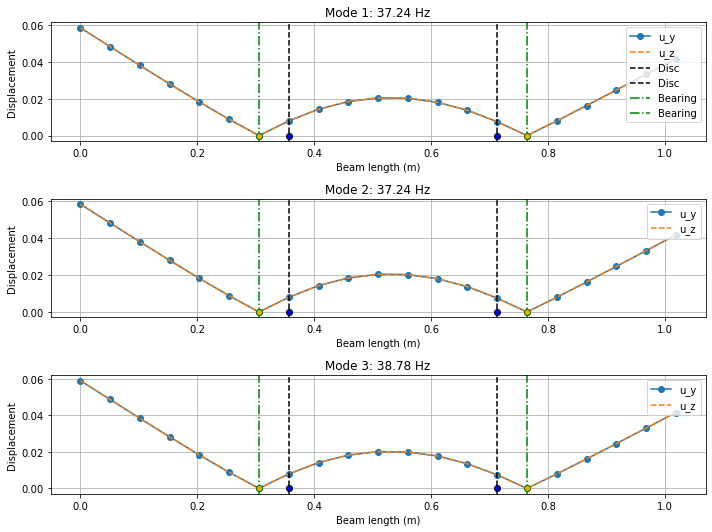

In [50]:
import numpy as np

# === Custom Bounds Defined in Main ===
custom_bounds = [
    (0.95, 1.15),          # Beam length [m]
    (0.005, 0.016),        # Beam D_outer [m]
    (0.08, 0.10),          # Disc radius [m]
    (0.006, 0.015),        # Disc thickness [m]
    (5, 8),                # Disc pos 1 [node]
    (14, 17),              # Disc pos 2 [node]
    (5, 8),                # Bearing pos 1 [node]
    (14, 17),              # Bearing pos 2 [node]
    (500, 1500)            # Rotation speed [rpm]
]


# === Run Optimization with Custom Bounds ===
beam, discs, bearings, Omega, result = run_optimization(custom_bounds)


# === Setup Rotor System ===
rotor = RotorSystem(beam, discs, bearings, Omega)
rotor.assemble_global_matrices()
rotor.apply_boundary_conditions()
rotor.solve_eigenproblem()


# === Show Frequencies ===
frequencies = rotor.get_frequencies()
print("\n=== Natural Frequencies (Hz) ===")
for i, f in enumerate(frequencies[:16]):
    print(f"Mode {i+1}: {f:.2f} Hz")


# === Print Beam Parameters ===
print("\n=== Beam Parameters ===")
print(f"Length         : {beam['length']:.4f} m")
print(f"Outer Diameter : {beam['D_outer']:.4f} m")
print(f"Density        : {beam['density']} kg/m^3")
print(f"E-Modulus      : {beam['E']:.2e} Pa")
print(f"Elements       : {beam['n_elem']}")

print("\n=== Disc Positions and Geometry ===")
for i, disc in enumerate(discs, start=1):
    print(f"Disc {i}: Node {disc['pos']}, Diameter {disc['diameter']:.4f} m, Thickness {disc['thickness']:.4f} m")

print("\n=== Bearing Positions ===")
for i, b in enumerate(bearings, start=1):
    print(f"Bearing {i}: Node {b['pos']}")

print(f"\n=== Rotational Speed ===\nOmega: {Omega:.2f} rad/s ({Omega * 60 / (2 * np.pi):.2f} rpm)")


# === Plot Mode Shapes ===
plotter = ModePlotter(rotor)
plotter.plot_2D_modes(n_modes=3)
#plotter.plot_3D_modes(n_modes=6)

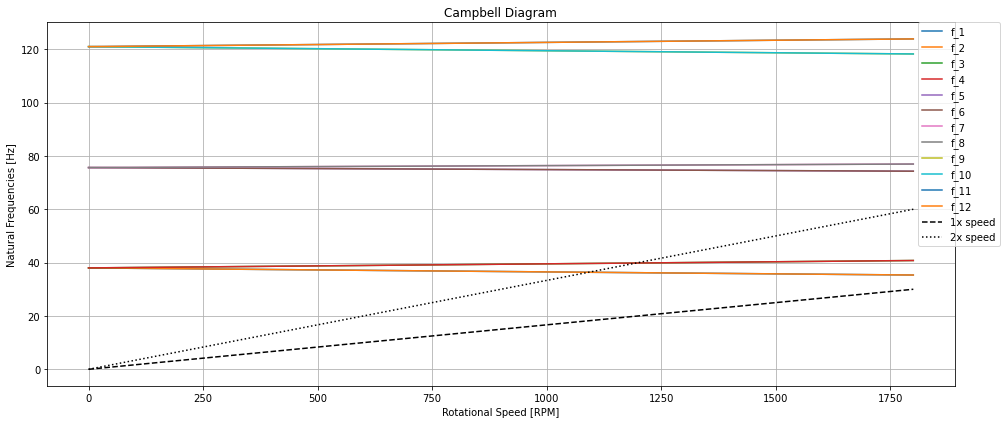

"\n1× speed\tShaft's rotational frequency (in Hz)\n2× speed\tFirst harmonic (twice the rotational freq.)\n"

In [51]:
# === Generate and Plot Campbell Diagram ===
rpm_range = np.arange(0, 1801, 50)
campbell_data = compute_campbell_diagram(rotor, rpm_range, n_modes=12)
plot_campbell_diagram(rpm_range, campbell_data)

"""
1× speed	Shaft's rotational frequency (in Hz)
2× speed	First harmonic (twice the rotational freq.)
"""